In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice
import random

In [ ]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from pytorch_lightning.loggers import CometLogger

COMET_API_KEY = "mGG8ZYUSg6Hggq8qkPII0Vwx9"
PROJECT_NAME = "pytorch-transformer-ts"
WORKSPACE = "rolandriachi"

logger = CometLogger(api_key=COMET_API_KEY,
                     project_name=PROJECT_NAME,
                     workspace=WORKSPACE
                    )

from estimator import LagGPTEstimator

In [ ]:
class CombinedDatasetIterator:
    def __init__(self, datasets, seed, weights):
        self._datasets = [iter(el) for el in datasets]
        self._weights = weights
        self._rng = random.Random(seed)

    def __next__(self):
        (dataset,) = self._rng.choices(self._datasets, weights=self._weights, k=1)
        return next(dataset)

In [ ]:
class CombinedDataset:
    def __init__(self, datasets, seed=None, weights=None):
        self._seed = seed
        self._datasets = datasets
        self._weights = weights
        n_datasets = len(datasets)
        if weights is None:
            self._weights = [1 / n_datasets] * n_datasets

    def __iter__(self):
        return CombinedDatasetIterator(self._datasets, self._seed, self._weights)
    
    def __len__(self):
        return sum([len(ds) for ds in self._datasets])

In [ ]:
gluonts_ds = [
        get_dataset("airpassengers").train,
        get_dataset("australian_electricity_demand").train,
        get_dataset("car_parts_without_missing").train,
        get_dataset("cif_2016").train,
        get_dataset("covid_deaths").train,
        get_dataset("electricity").train,
        get_dataset("electricity_weekly").train,
        get_dataset("exchange_rate").train,
        get_dataset("fred_md").train,
        get_dataset("hospital").train,
        get_dataset("kaggle_web_traffic_weekly").train,
        get_dataset("kdd_cup_2018_without_missing").train,
        get_dataset("london_smart_meters_without_missing").train,
        get_dataset("nn5_daily_with_missing").train,
        get_dataset("nn5_weekly").train,
        get_dataset("pedestrian_counts").train,
        get_dataset("rideshare_without_missing").train,
        get_dataset("saugeenday").train,
        get_dataset("solar-energy").train,
        get_dataset("solar_10_minutes").train,
        get_dataset("solar_weekly").train,
        get_dataset("taxi_30min").train,
        get_dataset("temperature_rain_without_missing").train,
        get_dataset("tourism_monthly").train,
        get_dataset("uber_tlc_daily").train,
        get_dataset("uber_tlc_hourly").train,
        get_dataset("vehicle_trips_without_missing").train,
        get_dataset("weather").train,
        get_dataset("wiki-rolling_nips").train,
        get_dataset("m4_daily").train,
        get_dataset("m4_hourly").train,
        get_dataset("m4_monthly").train,
        get_dataset("m4_quarterly").train,
        get_dataset("m4_yearly").train,
        get_dataset("wind_farms_without_missing").train,
]
dataset = CombinedDataset(gluonts_ds, weights=[sum([len(x["target"]) for x in d]) for d in gluonts_ds])

In [6]:
val_dataset = get_dataset("m4_weekly").test

In [7]:
meta = get_dataset("m4_weekly").metadata

In [36]:
estimator = LagGPTEstimator(
    prediction_length=meta.prediction_length,
    context_length=1024, # block_size: int = 2048 
    batch_size=32, # 4
    n_layer=4,
    n_head=4,
    n_embd=64, # 4096
    scaling="std",
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=100, accelerator="gpu", precision="16", logger=logger),
)
# Change num_batches_per_epoch <- 100 & max_epochs <- 100 & precision <- "bf16-mixed"

In [37]:
predictor = estimator.train(
    training_data=dataset, 
    validation_data=val_dataset,
    shuffle_buffer_length=1000
)

/home/mila/r/roland.riachi/base/lib/python3.10/site-packages/lightning_fabric/connector.py:554: UserWarning: 16 is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
  rank_zero_warn(
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/rolandriachi/pytorch-transformer-ts/33900469071b4dcdb5e0904eafd46a8e

/home/mila/r/roland.riachi/base/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint director

Epoch 0: : 100it [00:59,  1.69it/s, v_num=6a8e]                            
Validation: 0it [00:00, ?it/s]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: : 0it [00:00, ?it/s]
Validation DataLoader 0: : 1it [00:00, 60.12it/s]
Validation DataLoader 0: : 2it [00:00, 55.04it/s]
Validation DataLoader 0: : 3it [00:00, 50.84it/s]
Validation DataLoader 0: : 4it [00:00, 49.85it/s]
Validation DataLoader 0: : 5it [00:00, 49.64it/s]
Validation DataLoader 0: : 6it [00:00, 49.83it/s]
Validation DataLoader 0: : 7it [00:00, 49.21it/s]
Validation DataLoader 0: : 8it [00:00, 49.57it/s]
Validation DataLoader 0: : 9it [00:00, 50.26it/s]
Validation DataLoader 0: : 10it [00:00, 50.92it/s]
Validation DataLoader 0: : 11it [00:00, 51.52it/s]
Epoch 0: : 100it [00:59,  1.68it/s, v_num=6a8e, val_loss=7.860]
Epoch 0: : 100it [00:59,  1.68it/s, v_num=6a8e, val_loss=7.860, train_loss=-.605]

Epoch 0, global step 100: 'val_loss' reached 7.85665 (best 7.85665), saving model to '/home/mila/r/roland.riachi/p4-time-series/lag-gpt/pytorch-transformer-ts/33900469071b4dcdb5e0904eafd46a8e/checkpoints/epoch=0-step=100.ckpt' as top 1


Epoch 1: : 100it [00:58,  1.70it/s, v_num=6a8e, val_loss=7.860, train_loss=-.605]
Validation: 0it [00:00, ?it/s]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: : 0it [00:00, ?it/s]
Validation DataLoader 0: : 1it [00:00, 52.09it/s]
Validation DataLoader 0: : 2it [00:00, 49.72it/s]
Validation DataLoader 0: : 3it [00:00, 47.41it/s]
Validation DataLoader 0: : 4it [00:00, 46.71it/s]
Validation DataLoader 0: : 5it [00:00, 46.52it/s]
Validation DataLoader 0: : 6it [00:00, 46.72it/s]
Validation DataLoader 0: : 7it [00:00, 46.18it/s]
Validation DataLoader 0: : 8it [00:00, 46.46it/s]
Validation DataLoader 0: : 9it [00:00, 47.08it/s]
Validation DataLoader 0: : 10it [00:00, 47.70it/s]
Validation DataLoader 0: : 11it [00:00, 48.46it/s]
Epoch 1: : 100it [00:58,  1.70it/s, v_num=6a8e, val_loss=7.450, train_loss=-.605]
Epoch 1: : 100it [00:58,  1.70it/s, v_num=6a8e, val_loss=7.450, train_loss=-.979]

Epoch 1, global step 200: 'val_loss' reached 7.44821 (best 7.44821), saving model to '/home/mila/r/roland.riachi/p4-time-series/lag-gpt/pytorch-transformer-ts/33900469071b4dcdb5e0904eafd46a8e/checkpoints/epoch=1-step=200.ckpt' as top 1


Epoch 2: : 100it [01:01,  1.64it/s, v_num=6a8e, val_loss=7.450, train_loss=-.979]
Validation: 0it [00:00, ?it/s]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: : 0it [00:00, ?it/s]
Validation DataLoader 0: : 1it [00:00, 40.67it/s]
Validation DataLoader 0: : 2it [00:00, 42.58it/s]
Validation DataLoader 0: : 3it [00:00, 42.52it/s]
Validation DataLoader 0: : 4it [00:00, 43.05it/s]
Validation DataLoader 0: : 5it [00:00, 43.54it/s]
Validation DataLoader 0: : 6it [00:00, 44.09it/s]
Validation DataLoader 0: : 7it [00:00, 43.77it/s]
Validation DataLoader 0: : 8it [00:00, 44.23it/s]
Validation DataLoader 0: : 9it [00:00, 45.08it/s]
Validation DataLoader 0: : 10it [00:00, 45.69it/s]
Validation DataLoader 0: : 11it [00:00, 46.48it/s]
Epoch 2: : 100it [01:01,  1.63it/s, v_num=6a8e, val_loss=7.330, train_loss=-.979]
Epoch 2: : 100it [01:01,  1.63it/s, v_num=6a8e, val_loss=7.330, train_loss=-1.64]

Epoch 2, global step 300: 'val_loss' reached 7.33234 (best 7.33234), saving model to '/home/mila/r/roland.riachi/p4-time-series/lag-gpt/pytorch-transformer-ts/33900469071b4dcdb5e0904eafd46a8e/checkpoints/epoch=2-step=300.ckpt' as top 1


Epoch 3: : 100it [01:00,  1.66it/s, v_num=6a8e, val_loss=7.330, train_loss=-1.64]
Validation: 0it [00:00, ?it/s]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: : 0it [00:00, ?it/s]
Validation DataLoader 0: : 1it [00:00, 59.28it/s]
Validation DataLoader 0: : 2it [00:00, 54.58it/s]
Validation DataLoader 0: : 3it [00:00, 50.37it/s]
Validation DataLoader 0: : 4it [00:00, 49.38it/s]
Validation DataLoader 0: : 5it [00:00, 49.22it/s]
Validation DataLoader 0: : 6it [00:00, 49.42it/s]
Validation DataLoader 0: : 7it [00:00, 48.29it/s]
Validation DataLoader 0: : 8it [00:00, 48.70it/s]
Validation DataLoader 0: : 9it [00:00, 49.44it/s]
Validation DataLoader 0: : 10it [00:00, 50.15it/s]
Validation DataLoader 0: : 11it [00:00, 50.86it/s]
Epoch 3: : 100it [01:00,  1.66it/s, v_num=6a8e, val_loss=7.360, train_loss=-1.64]
Epoch 3: : 100it [01:00,  1.66it/s, v_num=6a8e, val_loss=7.360, train_loss=-1.27]

Epoch 3, global step 400: 'val_loss' was not in top 1


Epoch 4: : 100it [00:59,  1.68it/s, v_num=6a8e, val_loss=7.360, train_loss=-1.27]
Validation: 0it [00:00, ?it/s]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: : 0it [00:00, ?it/s]
Validation DataLoader 0: : 1it [00:00, 58.06it/s]
Validation DataLoader 0: : 2it [00:00, 34.13it/s]
Validation DataLoader 0: : 3it [00:00, 29.10it/s]
Validation DataLoader 0: : 4it [00:00, 27.38it/s]
Validation DataLoader 0: : 5it [00:00, 26.54it/s]
Validation DataLoader 0: : 6it [00:00, 26.11it/s]
Validation DataLoader 0: : 7it [00:00, 25.62it/s]
Validation DataLoader 0: : 8it [00:00, 25.47it/s]
Validation DataLoader 0: : 9it [00:00, 25.46it/s]
Validation DataLoader 0: : 10it [00:00, 25.48it/s]
Validation DataLoader 0: : 11it [00:00, 26.88it/s]
Epoch 4: : 100it [00:59,  1.67it/s, v_num=6a8e, val_loss=7.200, train_loss=-1.27]
Epoch 4: : 100it [00:59,  1.67it/s, v_num=6a8e, val_loss=7.200, train_loss=-1.49]

Epoch 4, global step 500: 'val_loss' reached 7.20162 (best 7.20162), saving model to '/home/mila/r/roland.riachi/p4-time-series/lag-gpt/pytorch-transformer-ts/33900469071b4dcdb5e0904eafd46a8e/checkpoints/epoch=4-step=500.ckpt' as top 1


Epoch 5: : 100it [01:01,  1.63it/s, v_num=6a8e, val_loss=7.200, train_loss=-1.49]
Validation: 0it [00:00, ?it/s]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: : 0it [00:00, ?it/s]
Validation DataLoader 0: : 1it [00:00, 60.13it/s]
Validation DataLoader 0: : 2it [00:00, 55.05it/s]
Validation DataLoader 0: : 3it [00:00, 50.67it/s]
Validation DataLoader 0: : 4it [00:00, 49.72it/s]
Validation DataLoader 0: : 5it [00:00, 49.57it/s]
Validation DataLoader 0: : 6it [00:00, 49.77it/s]
Validation DataLoader 0: : 7it [00:00, 49.13it/s]
Validation DataLoader 0: : 8it [00:00, 49.48it/s]
Validation DataLoader 0: : 9it [00:00, 50.18it/s]
Validation DataLoader 0: : 10it [00:00, 50.84it/s]
Validation DataLoader 0: : 11it [00:00, 51.72it/s]
Epoch 5: : 100it [01:01,  1.63it/s, v_num=6a8e, val_loss=7.290, train_loss=-1.49]
Epoch 5: : 100it [01:01,  1.63it/s, v_num=6a8e, val_loss=7.290, train_loss=-1.99]

Epoch 5, global step 600: 'val_loss' was not in top 1


Epoch 6: : 100it [01:02,  1.61it/s, v_num=6a8e, val_loss=7.290, train_loss=-1.99]
Validation: 0it [00:00, ?it/s]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: : 0it [00:00, ?it/s]
Validation DataLoader 0: : 1it [00:00, 44.22it/s]
Validation DataLoader 0: : 2it [00:00, 31.25it/s]
Validation DataLoader 0: : 3it [00:00, 27.65it/s]
Validation DataLoader 0: : 4it [00:00, 27.02it/s]
Validation DataLoader 0: : 5it [00:00, 26.52it/s]
Validation DataLoader 0: : 6it [00:00, 26.64it/s]
Validation DataLoader 0: : 7it [00:00, 26.04it/s]
Validation DataLoader 0: : 8it [00:00, 25.83it/s]
Validation DataLoader 0: : 9it [00:00, 26.06it/s]
Validation DataLoader 0: : 10it [00:00, 26.01it/s]
Validation DataLoader 0: : 11it [00:00, 27.42it/s]
Epoch 6: : 100it [01:02,  1.60it/s, v_num=6a8e, val_loss=7.060, train_loss=-1.99]
Epoch 6: : 100it [01:02,  1.60it/s, v_num=6a8e, val_loss=7.060, train_loss=-2.13]

Epoch 6, global step 700: 'val_loss' reached 7.06272 (best 7.06272), saving model to '/home/mila/r/roland.riachi/p4-time-series/lag-gpt/pytorch-transformer-ts/33900469071b4dcdb5e0904eafd46a8e/checkpoints/epoch=6-step=700.ckpt' as top 1


Epoch 7: : 100it [01:05,  1.52it/s, v_num=6a8e, val_loss=7.060, train_loss=-2.13]
Validation: 0it [00:00, ?it/s]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: : 0it [00:00, ?it/s]
Validation DataLoader 0: : 1it [00:00, 59.08it/s]
Validation DataLoader 0: : 2it [00:00, 54.44it/s]
Validation DataLoader 0: : 3it [00:00, 50.12it/s]
Validation DataLoader 0: : 4it [00:00, 49.17it/s]
Validation DataLoader 0: : 5it [00:00, 49.01it/s]
Validation DataLoader 0: : 6it [00:00, 49.24it/s]
Validation DataLoader 0: : 7it [00:00, 48.62it/s]
Validation DataLoader 0: : 8it [00:00, 49.00it/s]
Validation DataLoader 0: : 9it [00:00, 49.71it/s]
Validation DataLoader 0: : 10it [00:00, 50.39it/s]
Validation DataLoader 0: : 11it [00:00, 51.18it/s]
Epoch 7: : 100it [01:06,  1.51it/s, v_num=6a8e, val_loss=7.050, train_loss=-2.13]
Epoch 7: : 100it [01:06,  1.51it/s, v_num=6a8e, val_loss=7.050, train_loss=-2.03]

Epoch 7, global step 800: 'val_loss' reached 7.04893 (best 7.04893), saving model to '/home/mila/r/roland.riachi/p4-time-series/lag-gpt/pytorch-transformer-ts/33900469071b4dcdb5e0904eafd46a8e/checkpoints/epoch=7-step=800.ckpt' as top 1


Epoch 8: : 100it [01:02,  1.59it/s, v_num=6a8e, val_loss=7.050, train_loss=-2.03]
Validation: 0it [00:00, ?it/s]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0: : 0it [00:00, ?it/s]
Validation DataLoader 0: : 1it [00:00, 60.95it/s]
Validation DataLoader 0: : 2it [00:00, 55.46it/s]
Validation DataLoader 0: : 3it [00:00, 50.91it/s]
Validation DataLoader 0: : 4it [00:00, 49.87it/s]
Validation DataLoader 0: : 5it [00:00, 49.62it/s]
Validation DataLoader 0: : 6it [00:00, 49.81it/s]
Validation DataLoader 0: : 7it [00:00, 49.19it/s]
Validation DataLoader 0: : 8it [00:00, 49.54it/s]
Validation DataLoader 0: : 9it [00:00, 50.24it/s]
Validation DataLoader 0: : 10it [00:00, 50.84it/s]
Validation DataLoader 0: : 11it [00:00, 51.32it/s]
Epoch 8: : 100it [01:03,  1.58it/s, v_num=6a8e, val_loss=7.040, train_loss=-2.03]
Epoch 8: : 100it [01:03,  1.58it/s, v_num=6a8e, val_loss=7.040, train_loss=-1.98]

Epoch 8, global step 900: 'val_loss' reached 7.03881 (best 7.03881), saving model to '/home/mila/r/roland.riachi/p4-time-series/lag-gpt/pytorch-transformer-ts/33900469071b4dcdb5e0904eafd46a8e/checkpoints/epoch=8-step=900.ckpt' as top 1


Epoch 9: : 69it [00:48,  1.43it/s, v_num=6a8e, val_loss=7.040, train_loss=-1.98] 

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/rolandriachi/pytorch-transformer-ts/33900469071b4dcdb5e0904eafd46a8e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [9] : (-2.1257266998291016, -0.6053866744041443)
COMET INFO:     val_loss [9]   : (7.0388102531433105, 7.8566508293151855)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Parameters:
COMET INFO:     aug_prob                          : 0.1
COMET INFO:     aug_rate                          : 0.1
COMET INFO:     loss                              : beta=0.0
COMET INFO:     lr                                : 0.001
COMET INFO:     model_kwargs/context_le

ValueError: Expected parameter df (Tensor of shape (32, 1036)) of distribution Chi2() to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[2.9036, 2.8832, 2.8807,  ..., 2.2630, 2.2641, 2.2680],
        [2.0980, 2.0980, 2.0980,  ..., 2.0980, 2.0980, 2.0980],
        [2.2346, 2.2461, 2.2408,  ..., 2.5038, 2.2733, 2.3083],
        ...,
        [2.2664, 2.2687, 2.2706,  ..., 2.2369, 2.2398, 2.2336],
        [2.0980, 2.0980, 2.0980,  ..., 2.0980, 2.0980, 2.0980],
        [2.0980, 2.0980, 2.0980,  ..., 2.0980, 2.0980, 2.0980]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [12]:
test_dataset = get_dataset("traffic").test

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_dataset, predictor=predictor
)

In [ ]:
forecasts = list(forecast_it)

In [ ]:
tss = list(ts_it)

In [ ]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(
    iter(tss), iter(forecasts), num_series=len(test_dataset)
)


Running evaluation: 100%|██████████| 6034/6034 [00:02<00:00, 2316.62it/s]


In [33]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(
    iter(tss[:1000]), iter(forecasts[:1000]), num_series=1000
)

Running evaluation: 100%|██████████| 1000/1000 [00:01<00:00, 562.40it/s]
/home/mila/r/roland.riachi/base/lib/python3.10/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/mila/r/roland.riachi/base/lib/python3.10/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/mila/r/roland.riachi/base/lib/python3.10/site-packages/gluonts/evaluation/_base.py:422: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/mila/r/roland.riachi/base/lib/python3.10/site-packages/pandas/core/dtypes/astype.py:138: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)


In [24]:
agg_metrics

{'MSE': 0.0015466555594824828,
 'abs_error': 1.7559873163700104,
 'abs_target_sum': 4.513999849557877,
 'abs_target_mean': 0.06944615153165964,
 'seasonal_error': 0.017650951088167655,
 'MASE': 1.42741306854105,
 'MAPE': 0.3416493562551645,
 'sMAPE': 0.37925519943237307,
 'MSIS': 19.54518595834432,
 'QuantileLoss[0.1]': 0.6106239095330239,
 'Coverage[0.1]': 0.13846153846153847,
 'QuantileLoss[0.2]': 0.9888393431901932,
 'Coverage[0.2]': 0.16923076923076924,
 'QuantileLoss[0.3]': 1.2851681431755424,
 'Coverage[0.3]': 0.21538461538461542,
 'QuantileLoss[0.4]': 1.538294268772006,
 'Coverage[0.4]': 0.2615384615384616,
 'QuantileLoss[0.5]': 1.7559873824939132,
 'Coverage[0.5]': 0.3230769230769231,
 'QuantileLoss[0.6]': 1.9172822661697861,
 'Coverage[0.6]': 0.3384615384615385,
 'QuantileLoss[0.7]': 2.0307419935241344,
 'Coverage[0.7]': 0.3384615384615385,
 'QuantileLoss[0.8]': 2.0395083248615267,
 'Coverage[0.8]': 0.4,
 'QuantileLoss[0.9]': 1.824924959987402,
 'Coverage[0.9]': 0.430769230769

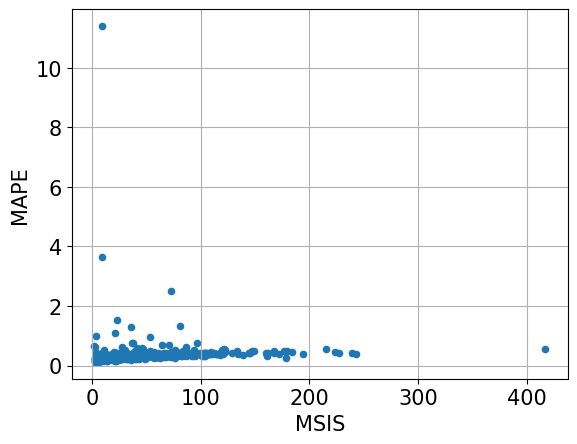

In [34]:
ts_metrics.plot(x="MSIS", y="MAPE", kind="scatter")
plt.grid(which="both")
plt.show()

In [ ]:
plt.figure(figsize=(20, 15))
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)
    forecast.plot(color='g')
    ts[-3 * 24:][0].plot(label="target")
    plt.xticks(rotation=60)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()